In [2]:
# Core dependencies
!pip install tensorflow==2.12.0
!pip install --upgrade torch transformers torchdata  # includes torchdata if needed

# PEFT and low-rank adaptation libraries
!pip install -U loralib peft

# Performance and evaluation tools
!pip install -q bitsandbytes accelerate evaluate rouge_score

# Specific version for `trl` library, if required by your project
!pip install -qqq trl==0.7.1

  Using cached torch-2.5.1-cp310-cp310-manylinux1_x86_64.whl.metadata (28 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [9]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType, PeftModel, PeftConfig
import evaluate
metric = evaluate.load("accuracy")
from datasets import load_dataset, DatasetDict
import accelerate

import evaluate
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

In [4]:
!python --version
!nvcc --version
!pip install nvcc4jupyter
%load_ext nvcc4jupyter

Python 3.10.12
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmpvo3upqbb".


In [5]:
%%cuda
#include <stdio.h>
__global__ void hello(){
 printf(“Hello from block: %u, thread: %u\n”, blockIdx.x, threadIdx.x);
}
int main(){
 hello<<<2, 2>>>();
 cudaDeviceSynchronize();
}

/tmp/tmpvo3upqbb/bcd893d1-4649-48ed-ac14-a2f25700d51e/single_file.cu:3:9: error: extended character “ is not valid in an identifier
    3 |  printf(“Hello from block: %u, thread: %u\n”, blockIdx.x, threadIdx.x);
      |         ^
/tmp/tmpvo3upqbb/bcd893d1-4649-48ed-ac14-a2f25700d51e/single_file.cu:3:43: error: extended character ” is not valid in an identifier
    3 |  printf(“Hello from block: %u, thread: %u\n”, blockIdx.x, threadIdx.x);
      |                                           ^



In [6]:
import torch

# Confirm CUDA availability
print("CUDA available:", torch.cuda.is_available())

# Check CUDA device
if torch.cuda.is_available():
    print("Using device:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available.")

CUDA available: True
Using device: Tesla T4


In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Running on:', device)

Running on: cuda


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
YT = pd.read_csv('/content/drive/MyDrive/DATA/YT-titles-transcripts-clean.csv', on_bad_lines='skip')

In [11]:
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text

In [12]:
YT['transcript'] = YT['transcript'].apply(clean_text)
YT['title'] = YT['title'].apply(clean_text)

In [13]:
YT.to_csv('YT_corrected.csv')

In [14]:
seperator_print_short = '-'.join('' for x in range(100))
seperator_print_long = '-'.join('' for x in range(140))

def print_input_outputs(i, index, input, label, model_output):
    print(seperator_print_long)

    print(f"Sample {i+1}: Index = {index}")
    print(seperator_print_short)

    print(f"INPUT:")
    print(input)
    print(seperator_print_short)

    print("DATASET ORIGINAL LABEL:")
    print(label)
    print(seperator_print_short)

    if model_output != "":
        print("OUTPUT OF THE MODEL")
        print(model_output)
        print(seperator_print_short)

    print(seperator_print_long)

In [15]:
dataset_src = "/content/YT_corrected.csv"
dataset_origin = load_dataset('csv',
                       data_files=dataset_src
                       )
dataset_origin

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'vid_id', 'title', 'transcript', 'category_1', 'category_2', 'task_id', 'punctuated', 'transcript_num_chars', 'default_language', 'default_audio_language'],
        num_rows: 17885
    })
})

In [16]:
dset_train_test = (load_dataset('csv',
                        data_files=dataset_src,
                        split='train'
                        )
          .train_test_split(train_size=0.7)
          )

dset_train_test

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'vid_id', 'title', 'transcript', 'category_1', 'category_2', 'task_id', 'punctuated', 'transcript_num_chars', 'default_language', 'default_audio_language'],
        num_rows: 12519
    })
    test: Dataset({
        features: ['Unnamed: 0', 'vid_id', 'title', 'transcript', 'category_1', 'category_2', 'task_id', 'punctuated', 'transcript_num_chars', 'default_language', 'default_audio_language'],
        num_rows: 5366
    })
})

In [17]:
dset_test_val = dset_train_test["test"].train_test_split(train_size=0.75)
# train --> validation
# test --> test
dset_test_val

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'vid_id', 'title', 'transcript', 'category_1', 'category_2', 'task_id', 'punctuated', 'transcript_num_chars', 'default_language', 'default_audio_language'],
        num_rows: 4024
    })
    test: Dataset({
        features: ['Unnamed: 0', 'vid_id', 'title', 'transcript', 'category_1', 'category_2', 'task_id', 'punctuated', 'transcript_num_chars', 'default_language', 'default_audio_language'],
        num_rows: 1342
    })
})

In [18]:
dataset = DatasetDict({
                      'train': dset_train_test['train'],
                      'validation': dset_test_val['train'],
                      'test': dset_test_val['test']}
                      )

dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'vid_id', 'title', 'transcript', 'category_1', 'category_2', 'task_id', 'punctuated', 'transcript_num_chars', 'default_language', 'default_audio_language'],
        num_rows: 12519
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'vid_id', 'title', 'transcript', 'category_1', 'category_2', 'task_id', 'punctuated', 'transcript_num_chars', 'default_language', 'default_audio_language'],
        num_rows: 4024
    })
    test: Dataset({
        features: ['Unnamed: 0', 'vid_id', 'title', 'transcript', 'category_1', 'category_2', 'task_id', 'punctuated', 'transcript_num_chars', 'default_language', 'default_audio_language'],
        num_rows: 1342
    })
})

In [19]:
dataset = DatasetDict({
                      'train': dset_train_test['train'],
                      'validation': dset_test_val['train'],
                      'test': dset_test_val['test']}
                      )

dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'vid_id', 'title', 'transcript', 'category_1', 'category_2', 'task_id', 'punctuated', 'transcript_num_chars', 'default_language', 'default_audio_language'],
        num_rows: 12519
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'vid_id', 'title', 'transcript', 'category_1', 'category_2', 'task_id', 'punctuated', 'transcript_num_chars', 'default_language', 'default_audio_language'],
        num_rows: 4024
    })
    test: Dataset({
        features: ['Unnamed: 0', 'vid_id', 'title', 'transcript', 'category_1', 'category_2', 'task_id', 'punctuated', 'transcript_num_chars', 'default_language', 'default_audio_language'],
        num_rows: 1342
    })
})

In [20]:
INPUT_COL_NAME = "transcript"
OUTPUT_COL_NAME = "title"

In [21]:
samples_to_check = [10, 15]

for i, index in enumerate(samples_to_check):
    print_input_outputs(i,
                        index,
                        input=dataset['train'][index][INPUT_COL_NAME],
                        label=dataset['train'][index][OUTPUT_COL_NAME],
                        model_output = "")

-------------------------------------------------------------------------------------------------------------------------------------------
Sample 1: Index = 10
---------------------------------------------------------------------------------------------------
INPUT:
hello bow tie vet guy i recently found this dog on the street hes very cute his name is chase he still has his testicles do i need to get them like i dont know i dont know the answer to that question im totally kidding do dogs and cats have to get neutered or spayed yes lets go with neutering first so neutering is removing the testicles from the dog theyre not going to keep reproducing and thats probably the number one reason we do it number two are there some health benefits to neutering them absolutely if they dont have testicles they dont get testicular cancer as they get older they dont get that benign prostatic enlargement the prostate can get very large as theyre getting old and can actually make it difficult for the

BNB Config

In [22]:
# model_id='facebook/bart-base'
model_id='google/flan-t5-base'
# model_id='google/flan-t5-small'
# model_id='lucadiliello/bart-small'

model = AutoModelForSeq2SeqLM.from_pretrained(model_id,
                                              # quantization_config = BNB_NF4_CONFIG,
                                              # device_map = "auto"
                                              )

tokenizer = AutoTokenizer.from_pretrained(model_id,
                                          use_fast=True,
                                          )

# # config tokenizer: assign the eos_token to the pad_token
# tokenizer.pad_token = tokenizer.eos_token
# tokenizer.padding_side = "right"

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [23]:
for i, index in enumerate(samples_to_check):
    transcript = dataset['train'][index][INPUT_COL_NAME]
    title = dataset['train'][index][OUTPUT_COL_NAME]

    inputs = tokenizer(transcript, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"],
            max_new_tokens=25,
        )[0],
        skip_special_tokens=True
    )

    print_input_outputs(i,
                        index,
                        input=transcript,
                        label=title,
                        model_output=output)

Token indices sequence length is longer than the specified maximum sequence length for this model (1746 > 512). Running this sequence through the model will result in indexing errors


-------------------------------------------------------------------------------------------------------------------------------------------
Sample 1: Index = 10
---------------------------------------------------------------------------------------------------
INPUT:
hello bow tie vet guy i recently found this dog on the street hes very cute his name is chase he still has his testicles do i need to get them like i dont know i dont know the answer to that question im totally kidding do dogs and cats have to get neutered or spayed yes lets go with neutering first so neutering is removing the testicles from the dog theyre not going to keep reproducing and thats probably the number one reason we do it number two are there some health benefits to neutering them absolutely if they dont have testicles they dont get testicular cancer as they get older they dont get that benign prostatic enlargement the prostate can get very large as theyre getting old and can actually make it difficult for the

In [24]:
for i, index in enumerate(samples_to_check):
    transcript = dataset['train'][index][INPUT_COL_NAME]
    title = dataset['train'][index][OUTPUT_COL_NAME]

    prompt=f'''
    Generate a title related to the given transcript:
    {transcript}

    Generated Title:
    '''

    inputs=tokenizer(prompt,return_tensors='pt')
    output=tokenizer.decode(
        model.generate(
            inputs['input_ids'],
            max_new_tokens=512,
        )[0],
        skip_special_tokens=True
    )

    print_input_outputs(i,
                        index,
                        input=prompt,
                        label=title,
                        model_output=output)


-------------------------------------------------------------------------------------------------------------------------------------------
Sample 1: Index = 10
---------------------------------------------------------------------------------------------------
INPUT:

    Generate a title related to the given transcript:
    hello bow tie vet guy i recently found this dog on the street hes very cute his name is chase he still has his testicles do i need to get them like i dont know i dont know the answer to that question im totally kidding do dogs and cats have to get neutered or spayed yes lets go with neutering first so neutering is removing the testicles from the dog theyre not going to keep reproducing and thats probably the number one reason we do it number two are there some health benefits to neutering them absolutely if they dont have testicles they dont get testicular cancer as they get older they dont get that benign prostatic enlargement the prostate can get very large as th

In [25]:
def create_one_shot_prompt(base_given_dialogues, test_dialgoue_index):
    prompt='There is an example dialogue with its summary:'

    # add base samples in prompt firstly
    for index in base_given_dialogues:
      transcript = dataset['test'][index][INPUT_COL_NAME]
      title = dataset['test'][index][OUTPUT_COL_NAME]

      prompt+=f"""
              Given transcript:
              {transcript}

              The title of the transcript given above:
              {title}
              """

    # add test transcript
    test_transcript = dataset['test'][test_dialgoue_index][INPUT_COL_NAME]
    prompt+=f"""
              Generate a title related to the given transcript:
              {test_transcript}

              Generated title:
              """
    return prompt

In [26]:
base_given_dialogues=[10]
test_dialgoue_index=20

# input (with one shot prompt)
one_shot_prompt = create_one_shot_prompt(base_given_dialogues, test_dialgoue_index)
print(one_shot_prompt)
print("\n\n\n")

# label
title_new = dataset['test'][test_dialgoue_index][OUTPUT_COL_NAME]

# model output
inputs=tokenizer(one_shot_prompt,return_tensors='pt')
output=tokenizer.decode(
    model.generate(
        inputs['input_ids'],
        max_new_tokens=512,
    )[0],
    skip_special_tokens=True
)

print_input_outputs(i,
                    index,
                    input=one_shot_prompt,
                    label=title_new,
                    model_output=output)


There is an example dialogue with its summary:
              Given transcript:
              making a working mermaid potion can be very difficult but it is possible first youll need some sea shells grind them up in a pestle and mortar until you get a fine powder pour the powder into some salt water sea water is best but salted tap water is fine next youll need the heart of a kelapine squeeze out the innards into your mixture then youre going to need some finely sliced kumerial bandit about three strips should be enough finally youll need some rustican barbantiun finely chop this and add it to your mixture stir well and serve over ice the change will normally take place over night so ensure you sleep without any clothes on the lower half of your body if youd like to find out how to make a simple love potion click here and remember to subscribe for more potions and spells

              The title of the transcript given above:
              how to become a mermaid  a potion that really 

Model

In [27]:
def trainable_model_params(model):
  trainable_params=0
  all_params=0
  for _,param in model.named_parameters():
    all_params+=param.numel()
    if param.requires_grad:
      trainable_params+=param.numel()
  return f"trainable params: {trainable_params}\nall params: {all_params}\npercentage of trainable params: {100*trainable_params/all_params}"
print(trainable_model_params(model))

trainable params: 247577856
all params: 247577856
percentage of trainable params: 100.0


LoRA

In [28]:
LORA_R = 8
LORA_ALPHA = 64         # scaling coefficient for LoRA
LORA_DROPOUT = 0.01

lora_config=LoraConfig(
    r = LORA_R,
    lora_alpha = LORA_ALPHA,
    # target_modules = ["q_proj","v_proj"],
    target_modules=["q", "v"],
    lora_dropout = LORA_DROPOUT,
    bias = "lora_only",                     # check with "none"
    task_type = TaskType.SEQ_2_SEQ_LM
)

# model.enable_input_require_grads()

peft_model=get_peft_model(model,lora_config)

print(trainable_model_params(peft_model))

trainable params: 884736
all params: 248462592
percentage of trainable params: 0.3560841867092814


In [29]:
def tokenize_function(example):
    START_prompt = 'Generate a relevant title related to the given transcript:'
    END_prompt = '\n\nGenerated Title: '

    prompt = [START_prompt + transcript + END_prompt for transcript in example[INPUT_COL_NAME]]
    example['input_ids'] = tokenizer(prompt,
                                    padding="max_length",
                                    truncation=True,
                                    return_tensors="pt").input_ids

    example['labels'] = tokenizer(example["title"],
                                  padding="max_length",
                                  truncation=True,
                                  return_tensors="pt").input_ids

    return example


tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['Unnamed: 0', 'vid_id', 'title', 'transcript', 'category_1', 'category_2', 'task_id', 'punctuated', 'transcript_num_chars', 'default_language', 'default_audio_language'])


Map:   0%|          | 0/12519 [00:00<?, ? examples/s]

Map:   0%|          | 0/4024 [00:00<?, ? examples/s]

Map:   0%|          | 0/1342 [00:00<?, ? examples/s]

In [30]:
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 12519
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 4024
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 1342
    })
})


In [31]:
output_model_name = "t5"
output_config_option = "peft-lora"
output_task = "title-generation"
output_ver = "v1-1"

OUTPUT_DIR = f'./{output_model_name}-{output_config_option}-{output_task}-{output_ver}'

In [32]:
# MAIN PARAMS
NUM_EPOCHS = 6
L_RATE = 2e-4
TRAIN_OPTIMIZER = "paged_adamw_32bit"      # "paged_adamw_32bit"

# OTHER PARAMS
EVAL_STEPS = 0.2
LR_SCHED_TYPE = "cosine"

peft_training_args = TrainingArguments(
    output_dir = OUTPUT_DIR,

    num_train_epochs = NUM_EPOCHS,
    per_device_train_batch_size = 4,
    gradient_accumulation_steps = 2, # accumulating gradients over several batches

    learning_rate = L_RATE,
    optim = TRAIN_OPTIMIZER,
    lr_scheduler_type = LR_SCHED_TYPE,
    # max_grad_norm = 0.4,             # for gradient clipping
    # warmup_ratio = 0.02,             # ratio of total training steps used in [0, LR]

    logging_steps = 4,
    do_train = True,
    do_eval = True,
    evaluation_strategy = "epoch",      # set "steps" to see each val step
    # eval_steps = 4,
    # logging_strategy= "epoch",

    logging_dir = f"{OUTPUT_DIR}/logs",
    # save_strategy = "epoch",

    # load_best_model_at_end = True,
    # save_total_limit=2,
    metric_for_best_model = 'eval_loss',
    save_strategy = "epoch"

)

model.config.use_cache = False

peft_trainer = Trainer(
    model = peft_model,
    args = peft_training_args,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets['validation'],
    # compute_metrics=compute_metrics
    # neftune_noise_alpha=5,             # use NEFTune
    # data_collator=data_collator,
    # max_seq_length=1024,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [33]:
T_START_TRAIN = time.time()
peft_trainer.train()
T_END_TRAIN = time.time()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.088600,0.074853
2,0.086900,0.071544
3,0.079400,0.070846
4,0.069600,0.069335
5,0.069500,0.069064
6,0.067400,0.069029


In [34]:
PATH_peft_model="./t5-lora-title-generator-checkpoint-1-1"

peft_trainer.model.save_pretrained(PATH_peft_model)
tokenizer.save_pretrained(PATH_peft_model)

('./t5-lora-title-generator-checkpoint-1-1/tokenizer_config.json',
 './t5-lora-title-generator-checkpoint-1-1/special_tokens_map.json',
 './t5-lora-title-generator-checkpoint-1-1/spiece.model',
 './t5-lora-title-generator-checkpoint-1-1/added_tokens.json',
 './t5-lora-title-generator-checkpoint-1-1/tokenizer.json')

In [35]:
# Load lora model and base LLM model together

peft_model = PeftModel.from_pretrained(model,
                                       PATH_peft_model, #PATH_peft_model
                                       torch_dtype=torch.bfloat16,
                                       is_trainable=False)

Test

In [36]:
TEST_INDEX = 22

transcript = dataset['test'][TEST_INDEX][INPUT_COL_NAME]
title = dataset['test'][TEST_INDEX][OUTPUT_COL_NAME]

prompt = f"""
Generate a title related to the given transcript:
{transcript}

Generated Title:
"""
inputs = tokenizer(prompt, return_tensors='pt')

output_peft = tokenizer.decode(
    peft_model.generate(
        input_ids = inputs['input_ids'].cuda(),
        generation_config = GenerationConfig(max_new_tokens=70,
                                             temperatue=1,
                                             do_sample=True),
    )[0],
    skip_special_tokens = True
)

output_base_model = tokenizer.decode(
    model.generate(
        input_ids = inputs['input_ids'].cuda(),
        generation_config = GenerationConfig(max_new_tokens=70,
                                             temperature=1,
                                             do_sample=True),
    )[0],
    skip_special_tokens = True
)

output_base_model_2 = tokenizer.decode(
    model.generate(
        input_ids = inputs['input_ids'].cuda(),
        generation_config = GenerationConfig( max_new_tokens=1024,
                                              temperature=1,
                                              do_sample=True),
    )[0],
    skip_special_tokens = True
)


print(prompt)
print(seperator_print_short)

print('Label:')
print(title)
print(seperator_print_short)

print('Original Model Summary:')
print(output_base_model)
print(seperator_print_short)

print('PEFT Summary:')
print(output_peft)
print(seperator_print_short)

print('PEFT Summary No Token len:')
print(output_base_model_2)


Generate a title related to the given transcript:
j hey brother ben you know whats always bothered me about star wars is how when it comes to the lightsabers blue and green were the good guys and red were the bad guys but when it came to the ships like the xwing and the tie fighters xwings have red lasers and tie fighters have green like even the death star laser is green like what gives what colors are good and what colors are bad like do the colors mean anything at all well today we are going to figure that out intro music j and ben hey brother j lightsabers have got to be the coolest object in the entire star wars universe nay any universe no kid who has ever seen star wars has not like immediately wanted a lightsaber in fact no adult who has ever seen star wars has not immediately wanted a lightsaber i keep putting it on my christmas list you guys keep not getting me one dont worry its okay im actually pretty good at pretending to have one lightsaber noises yeah fun fact everyone 

In [37]:
def get_decoded_prediction(transcript, max_target_length=40):

  inputs = tokenizer(transcript, return_tensors="pt").to(device)
  outputs = model.generate(**inputs, max_new_tokens=max_target_length)
  return tokenizer.decode(outputs[0], skip_special_tokens=True)

result_model_generation = get_decoded_prediction(transcript)
result_model_generation


'what do the colors mean'

Evaluate

In [38]:
peft_model.eval()

PeftModelForSeq2SeqLM(
  (base_model): LoraModel(
    (model): T5ForConditionalGeneration(
      (shared): Embedding(32128, 768)
      (encoder): T5Stack(
        (embed_tokens): Embedding(32128, 768)
        (block): ModuleList(
          (0): T5Block(
            (layer): ModuleList(
              (0): T5LayerSelfAttention(
                (SelfAttention): T5Attention(
                  (q): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=False)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.01, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=8, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=8, out_features=768, bias=False)
                    )
                    (lora_embedding_A): ParameterDict()
              

In [39]:
metric = evaluate.load("rouge")

def get_decoded_pred_samples(sample, max_target_length=40):
    ## predictions
    # generate summary
    # outputs = model.generate(input_ids=sample["input_ids"].unsqueeze(0).cuda(),
    #                          do_sample=True,
    #                         #  top_p=0.9,
    #                          max_new_tokens=max_target_length)

    outputs = peft_model.generate(input_ids=sample["input_ids"].unsqueeze(0).cuda(),
                             do_sample=True,
                            #  top_p=0.9,
                             max_new_tokens=max_target_length)



    outputs = model.generate(input_ids=sample["input_ids"].unsqueeze(0).cuda(),
                             do_sample=True,
                            #  top_p=0.9,
                             max_new_tokens=max_target_length)


    prediction = tokenizer.decode(outputs[0].detach().cpu().numpy(),
                                  skip_special_tokens=True)

    # Replace -100 in the labels which we can't decode them
    labels = np.where(sample['labels'] != -100,
                      sample['labels'],
                      tokenizer.pad_token_id)


    ## samples
    # decode eval sample
    labels = tokenizer.decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    return prediction, labels


In [40]:
test_dataset = tokenized_datasets['test'].with_format("torch")

df_list_elements = []

T_START_PRED = time.time()
# run predictions
predictions, references, = [] , []
for sample in tqdm(test_dataset):
    pred, y = get_decoded_pred_samples(sample, max_target_length=60)
    predictions.append(pred)
    references.append(y)

    df_list_elements.append([sample, y, pred])

100%|██████████| 1342/1342 [20:44<00:00,  1.08it/s]


In [41]:
for pred in predictions[:5]:
  print(pred)

vivian tries an egg gadget the dash rapid egg cooker
how to make simple wine making using fresh grapes
how differentials work
sandbox farm idea racetoytime
william shakespeare tells a story of the dark lady


In [42]:
# # string manipulation for predictions (delete prompt parts)
predictions_v1 = [pred.replace("Generate a relevant title related to the given transcript: ", " ") for pred in predictions]
predictions_v2 = [pred.strip() for pred in predictions_v1]
# predictions_v2 = [pred.strip() for pred in predictions]

In [43]:
rogue = metric.compute(predictions=predictions,
                       references=references,
                       use_stemmer=True)
T_END_PRED = time.time()


print(f"Rogue1: {rogue['rouge1']* 100:2f}%")
print(f"rouge2: {rogue['rouge2']* 100:2f}%")
print(f"rougeL: {rogue['rougeL']* 100:2f}%")
print(f"rougeLsum: {rogue['rougeLsum']* 100:2f}%")

Rogue1: 33.569310%
rouge2: 15.764788%
rougeL: 30.709217%
rougeLsum: 30.711782%


In [44]:
df_model_results = pd.DataFrame(df_list_elements,
                                columns=["sample", "label", "prediction"])

df_model_results = df_model_results.drop('sample', axis=1)
df_model_results['prediction'] = df_model_results['prediction'].apply(lambda x: x.replace("Generate a relevant title related to the given transcript: ", " "))
df_model_results['prediction'] = df_model_results['prediction'].apply(lambda x: x.replace("/", ""))
df_model_results['prediction'] = df_model_results['prediction'].apply(lambda x: x.replace("_", ""))
df_model_results['prediction'] = df_model_results['prediction'].apply(lambda x: x.strip())
df_model_results.to_csv('t5_6000_cs_abs_test_results_1.csv')
df_model_results

,label,prediction
0,nordic ware egg boiler vivian tries testing eg...,vivian tries an egg gadget the dash rapid egg ...
1,2 bought 10kg of grapes now what how to make f...,how to make simple wine making using fresh grapes
2,how a differential works,how differentials work
3,fun farm animals toys for kids lets make a far...,sandbox farm idea racetoytime
4,shakespeares sonnet 130 analysis and explanation,william shakespeare tells a story of the dark ...
...,...,...
1337,spill your guts or fill your guts w gordon ramsay,celebrity chefs food vs restaurant
1338,how many fingers kids songs super simple songs,counting toes how many fingers on one hand kat...
1339,100 years of school lunches taste test,grandmas school lunch the eat grandmas school ...
1340,how to make string christmas trees,string christmas trees for christmas pins and ...


In [45]:
print("time for training:",T_END_TRAIN - T_START_TRAIN)
print("time for prediction:",T_END_PRED - T_START_PRED)
print("lora r:",LORA_R)
print("lora alpha:",LORA_ALPHA)
print("lora alpha:",LORA_DROPOUT)
print(f"Len Training: {tokenized_datasets['train'].shape}")
print(f"Len Validation: {tokenized_datasets['validation'].shape}")
print(f"Len Test: {tokenized_datasets['test'].shape}")

time for training: 21502.14903664589
time for prediction: 1246.071179151535
lora r: 8
lora alpha: 64
lora alpha: 0.01
Len Training: (12519, 2)
Len Validation: (4024, 2)
Len Test: (1342, 2)


In [46]:
df_trainer_logs = pd.DataFrame(peft_trainer.state.log_history)

df_trainer_logs

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,39.5569,52.249603,1.999999e-04,0.002556,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36.7958,39.627991,1.999996e-04,0.005112,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,34.8233,47.752625,1.999992e-04,0.007668,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,31.7767,32.894905,1.999986e-04,0.010224,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,29.0066,34.604969,1.999978e-04,0.012780,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,0.0656,0.161155,5.596779e-10,5.993610,9380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2350,0.0776,0.223990,2.014842e-10,5.996166,9384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2351,0.0674,0.159973,2.238714e-11,5.998722,9388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2352,NaN,NaN,NaN,6.000000,9390,0.069029,428.8142,9.384,1.173,NaN,NaN,NaN,NaN,NaN


In [47]:
df_trainer_logs.to_csv('t5_6000_cs_abs_train_logs.csv')

In [48]:
df_trainer_logs = df_trainer_logs[["epoch","loss","eval_loss","learning_rate","step"]]
df_trainer_logs

,epoch,loss,eval_loss,learning_rate,step
0,0.002556,39.5569,NaN,1.999999e-04,4
1,0.005112,36.7958,NaN,1.999996e-04,8
2,0.007668,34.8233,NaN,1.999992e-04,12
3,0.010224,31.7767,NaN,1.999986e-04,16
4,0.012780,29.0066,NaN,1.999978e-04,20
...,...,...,...,...,...
2349,5.993610,0.0656,NaN,5.596779e-10,9380
2350,5.996166,0.0776,NaN,2.014842e-10,9384
2351,5.998722,0.0674,NaN,2.238714e-11,9388
2352,6.000000,NaN,0.069029,NaN,9390


Text(0, 0.5, 'Loss')

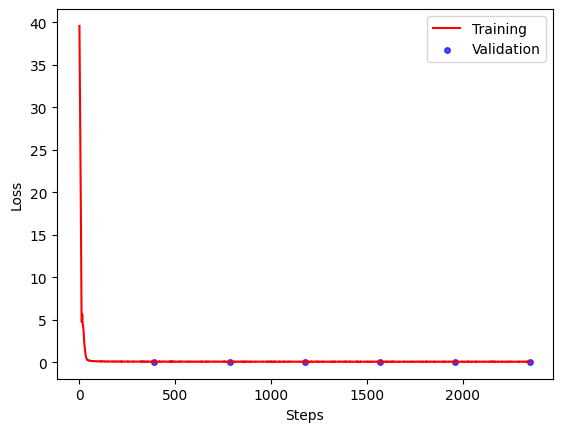

In [49]:
steps = df_trainer_logs.index
train_loss = df_trainer_logs.loss
eval_loss_list = df_trainer_logs.eval_loss

plt.plot(steps, train_loss, label="train_loss", color = "red")
plt.scatter(steps, eval_loss_list,
            c="blue", alpha=0.7, s=16)

plt.legend(["Training", "Validation"], loc ="upper right")
plt.xlabel("Steps")
plt.ylabel("Loss")

In [50]:
!pip install huggingface_hub

In [51]:
from peft import PeftModel, LoraConfig
from transformers import AutoModelForSeq2SeqLM

# Load the base model
base_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")

# Create a LoRA configuration
config = LoraConfig(r=16, lora_alpha=32, target_modules=["q", "v"], lora_dropout=0.1)

# Wrap the base model with PEFT (LoRA)
peft_model = PeftModel(base_model, config)

# Fine-tune the model (this part is assumed to happen in your code before merging)

# After training, merge the PEFT adapters into the base model
peft_model = peft_model.merge_and_unload()

# Now you can save the model or use it for inference

In [ ]:
#peft_model = peft_model.merge_and_unload()

In [52]:
from huggingface_hub import notebook_login
notebook_login()

In [53]:
peft_model.push_to_hub("title-generation1-for-YT-videos")

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/michc/title-generation1-for-YT-videos/commit/53ffe2c2baabd1118c826f53dbc7f1cb16414f69', commit_message='Upload T5ForConditionalGeneration', commit_description='', oid='53ffe2c2baabd1118c826f53dbc7f1cb16414f69', pr_url=None, pr_revision=None, pr_num=None)

In [54]:
tokenizer.push_to_hub("title-generation1-for-YT-videos")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/michc/title-generation1-for-YT-videos/commit/b963748e2506151ee57916b0318c05b4e566c7f5', commit_message='Upload tokenizer', commit_description='', oid='b963748e2506151ee57916b0318c05b4e566c7f5', pr_url=None, pr_revision=None, pr_num=None)

Memory Usage

In [55]:
import locale
print(locale.getpreferredencoding())

UTF-8


In [56]:
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [57]:
!pip install nvidia-ml-py3

  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19173 sha256=e09a08f6c02d5d06bab0a186da110623566ceb4da0b59d14c8c199b7a72d8e4e
  Stored in directory: /root/.cache/pip/wheels/5c/d8/c0/46899f8be7a75a2ffd197a23c8797700ea858b9b34819fbf9e
Successfully built nvidia-ml-py3


In [58]:
!nvidia-smi

Fri Nov  8 23:39:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              33W /  70W |  11281MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [59]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Tesla T4
Memory Usage:
Allocated: 1.0 GB
Cached:    10.9 GB


<ipython-input-59-5bb3b86cbd86>:5: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')
